In [1]:
import numpy as np
from numpy import pi
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Some rotation utility functions

def calculate_rotation_matrix(n,sin,cos):
    '''
    Rotatation matrix around a normal vector n
    By angle theta, passed in as <sin> = sin(theta) and
    <cos> = cos(theta)
    '''
    assert np.abs(la.norm(n) - 1) < 1e-3, 'n must be a unit vector'
    
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]
#     cos = np.sqrt(1-sin**2)
    R = np.zeros((3,3))
    R[0,0] = cos + n1**2 * (1-cos)
    R[0,1] = n1*n2*(1-cos) - n3*sin
    R[0,2] = n1*n3*(1-cos) + n2*sin
    R[1,0] = n1*n2*(1-cos) + n3*sin
    R[1,1] = cos + n2**2 * (1-cos)
    R[1,2] = n2*n3*(1-cos) - n1*sin
    R[2,0] = n1*n3*(1-cos) - n2*sin
    R[2,1] = n2*n3*(1-cos) + n1*sin
    R[2,2] = cos + n3**2 * (1-cos)
    
    return R

def rotate_to_z(v):
    '''
    Takes a vector v and rotates it to be aligned with the z axis
    '''
    normv = la.norm(v)
    v = v / normv
    z = np.array([0,0,1])
    # normal vector between v and z
    n = np.cross(v,z)
    # sin of angle by which to rotate
    sin = la.norm(n)
    cos = np.dot(v,z)
    n = n / sin
    R = calculate_rotation_matrix(n,sin,cos)
    vz = R @ v * normv
    return vz,n,sin

def rotate_z_to_v(z_noisy,v):
    '''
    Takes vector z_noisy and rotates it according to the same rotation
    that would align z with v
    '''
    z = np.array([0,0,1])
    n = np.cross(z,v)
    sin = la.norm(n)
    n = n / sin
    cos = np.dot(z,v)
    R = calculate_rotation_matrix(n,sin,cos)
    v_noisy = R @ z_noisy
    return v_noisy
    

In [34]:
def skew_symm(x):
    Sx = np.zeros((2,3))
    Sx[0,1] = -x[2]
    Sx[0,2] = x[1]
    Sx[1,0] = x[2]
    Sx[1,2] = -x[1]
    return Sx

In [3]:
def plot_pointing_vectors(ax, S, V):
    _,N = V.shape
    for i in range(N):
        # get endpoints
        ep1 = S[:,i]
        l = la.norm(ep1)*1.5
        ep2 = ep1 + l * V[:,i]
        ax.plot((ep1[0],ep2[0]),(ep1[1],ep2[1]),(ep1[2],ep2[2]),linewidth=1,zorder=-1)
        ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

In [23]:
def distribute_sensors(n_sensors,lb=5,ub=15):
    '''
    distribute the sensors in a hollowed sphere
    '''
    r = np.random.uniform(lb,ub,n_sensors)
    theta = np.random.uniform(0,np.pi,n_sensors)
    phi = np.random.uniform(0,2*np.pi,n_sensors)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    S = np.vstack((x,y,z))
    return S

def sensor_proj(S):
    '''
    calculate projection matrices for the sensors
    NOTE: Should this be done using V (noisy) instead of S (not noisy)?
    '''
    _,n_sensors = S.shape
    P = np.zeros((3,4,n_sensors))
    for i in range(n_sensors):
        p = S[:,i]
        tmpn = np.cross([0,0,1],p)
        tmpn /= la.norm(tmpn)
        up = np.cross(p,tmpn)
        up /= la.norm(up)
        
        L = -p / la.norm(p)
        tmpa = np.cross(L,up)
        tmpa /= la.norm(tmpa)
        tmpb = np.cross(tmpa,L)
        R = np.r_[tmpa,tmpb,-L].reshape((3,3))
        T = -R @ p
        P[:,:,i] = np.c_[R,T]
    return P
        

def form_V(S, a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    S_norm = la.norm(S,axis=0)
    V = -S / S_norm
    V = add_noise(a,b,sig_a,sig_b,V)
    return V
    
def form_G(S,V):
    '''
    Helper function for least squares triangulation
    G is the geometry matrix
    V1 is a matrix of unit pointing vectors
    '''
    _,n = S.shape
    I = np.tile(np.eye(3),(n,1))
    S_norm = la.norm(S,axis=0)
    V_temp = np.tile(V,(n,1))
    id_temp = np.kron(np.eye(n),np.ones((3,1)))
    V2 = V_temp * id_temp
    G = np.c_[I,V2]
    return G

def form_G_noisy(S,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    '''
    Helper function for least squares triangulation
    G is the geometry matrix
    V1 is a matrix of unit pointing vectors
    '''
    _,n = S.shape
    I = np.tile(np.eye(3),(n,1))
    S_norm = la.norm(S,axis=0)
    V1 = -S / S_norm
    V1 = add_noise(a,b,sig_a,sig_b,V1)
    V2 = np.tile(V1,(n,1))
    id_temp = np.kron(np.eye(n),np.ones((3,1)))
    V = V2 * id_temp
    G = np.c_[I,V]
    return G,V1

def add_noise(a, b, sig_a, sig_b, V):
    '''
    Add noise to V along axes a, b
    Characterized by standard deviations sig_a, sig_b
    Assuming that noise is white
    For the nth sensor, assume that z points in the direction of v_n
    y is positive in the camera-up direction
    x is positive such that x cross y = z (will be in the left direction)
    a and b should be orthogonal
    '''
    assert np.dot(a,b) < 1e-3, "a and b must be orthogonal"
    _,N = V.shape
    V_noisy = np.zeros_like(V)
    z = np.array([0,0,1])
    for i in range(N):
        # randomly perturb z along a, b
        theta_a = np.random.normal(0,sig_a,1)
        R_a = calculate_rotation_matrix(a,np.sin(theta_a),np.cos(theta_a))
        theta_b = np.random.normal(0,sig_b,1)
        R_b = calculate_rotation_matrix(b,np.sin(theta_b),np.cos(theta_b))
        z_noisy = R_a @ R_b @ z
        
        v = V[:,i]
        assert np.abs(la.norm(v) - 1) <= 1e-3, "V must be composed of unit column vectors"
        V_noisy[:,i] = rotate_z_to_v(z_noisy, v)
    
    return V_noisy

In [48]:
def ls_triangulate(S,V):
    _,n = S.shape
    G = form_G(S,V)
    r0 = np.reshape(S.T,(3*n,1))
    rt,_,_,_ = la.lstsq(G,r0)
    rt = rt.flatten()
    r = rt[:3]
    t = rt[3:]
    return r,t

def ls_triangulate_fullsim(S,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    _,n = S.shape
    V = form_V(S,a,b,sig_a,sig_b)
    G = form_G(S,V)
    
    r0 = np.reshape(S.T,(3*n,1))
    rt,_,_,_ = la.lstsq(G,r0)
    rt = rt.flatten()
    r = rt[:3]
    t = rt[3:]
    return r,t

## 15 sensor simulation

In [18]:
tgt = np.zeros(3)
n_sensors = 15
S = distribute_sensors(n_sensors,10,15)

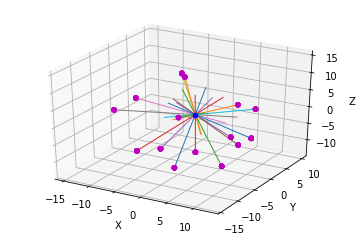

In [19]:
V = form_V(S)
G = form_G(S,V)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(tgt[0],tgt[1],tgt[2],c='b')
plt.show()

Noisy case, LS solution

Estimated coordinates: [0.0006733  0.29072107 0.06771415]
MSE: 0.08910439762881327


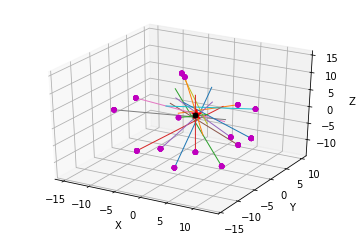

In [20]:
V = form_V(S,sig_a=.1,sig_b=.05)
est,_ = ls_triangulate(S,V)
mse = la.norm(est-tgt)**2
print('Estimated coordinates:',est)
print('MSE:',mse)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='k',s=25,zorder=0)
ax.scatter(est[0],est[1],est[2],c='r',marker='*',s=100,zorder=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Estimated coordinates: [-0.16724588  0.93420151  0.95093239]
MSE: 1.8049760641162718


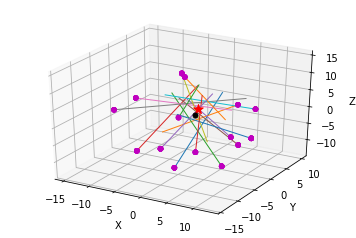

In [21]:
V = form_V(S,sig_a=.15,sig_b=.15)
est,_ = ls_triangulate(S,V)
mse = la.norm(est-tgt)**2
print('Estimated coordinates:',est)
print('MSE:',mse)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='k',s=25,zorder=0)
ax.scatter(est[0],est[1],est[2],c='r',marker='*',s=100,zorder=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Writing the Kalman Solution 
(which will be handled iteratively)

In [44]:
def calculate_ellipse_covariance(s,a,b,sig_a,sig_b):
    '''
    Finds covariance matrix of pointing vector error ellipse in world coordinates
    Takes in a,b which are major and minor error axes in camera coordinates
    sig_a,sig_b which are error variances 
    v, which is the pointing vector of the camera
    '''
    # First, construct matrix of left eigenvectors in camera coordinates
    # based on given error ellipse
    # Use the fact that a,b are eigenvectors and var_a,var_b are eigenvalues
    var_a = sig_a**2
    var_b = sig_b**2
    z_c = np.array([0,0,1])
    U_c = np.vstack((a,b,z_c)).T
    L = np.diag(np.array([var_a,var_b,0]))
    
    # Rotate U to be in the world coordinates
    v = -s / la.norm(s)
    n_w = np.cross(z_c,v)
    sin_theta_w = la.norm(n_w)
    n_w = n_w / sin_theta_w
    cos_theta_w = np.dot(z_c,v)
    R_theta_w = calculate_rotation_matrix(n_w,sin_theta_w,cos_theta_w)
    U_w = R_theta_w @ U_c # U_w is orthonormal so inv(U) = U.T
    
    return U_w @ L @ U_w.T

def calculate_ellipsoid_covariance(s1,s2,a1,a2,b1,b2,sig_a1,sig_a2,sig_b1,sig_b2):
    '''
    Finds covariance matrix of error ellipsoid for calculating triangulation
    given two sensors
    Takes in a,b which are major and minor error axes in camera coordinates
    sig_a,sig_b which are error variances 
    '''
    C1 = np.diag([sig_a1,sig_b1,0])
    C2 = np.diag([sig_a2,sig_b2,0])
    Cmid = np.block([[C1,np.zeros((3,3))],[np.zeros((3,3)),C2]])
    
    S = np.vstack((s1,s2)).T
    P = sensor_proj(S)
    P1 = P[:,:,0]
    P2 = P[:,:,1]
    
    x = np.array([0,0,1]) # supposedly each camera images in the center
    X = np.array([0,0,0,1]) # target is at the origin
    Sx = skew_symm(x)
    A = np.vstack(((Sx @ P1), (Sx @ P2)))
    
    P1X = P1 @ X
    P1X /= P1X[2]
    P2X = P2 @ X
    P2X /= P2X[2]
    
    B = np.block([[-skew_symm(P1X),np.zeros((2,3))],[np.zeros((2,3)),-skew_symm(P2X)]])
    
    N = A.T @ la.pinv( B @ Cmid @ B.T ) @ A
    return N

In [81]:
def kalman_simple(S,V,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    '''
    Assumes same error model for every sensor
    '''
    _,n = S.shape
    covars = np.zeros((3,3,n))
    ests = np.zeros((3,n))
    
    for i in range(n):
        s1 = S[:,i]
        s2 = S[:,i-1]
        
        # Triangulate between consecutive pairs
        S_tmp = np.vstack((s1,s2)).T
        v1 = V[:,i]
        v2 = V[:,i-1]
        V_tmp = np.vstack((v1,v2)).T
        ests[:,i],_ = ls_triangulate(S_tmp,V_tmp)
        
        # Covariance ellipsoid for the triangulation
        C = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b)
        covars[:,:,i] = C[:3,:3]
        
        
    # Kalman fusion
    # Just get the x coordinate for now
    y = ests[0,0] # initialize y, our solution
    C_y = covars[0,0,0] # initialize solution covariance
    for j in range(1,n):
        print('---------------------')
        print('Iteration', j)
        print('---------------------')
        x1 = y
        print('x1 = ', x1)
        x2 = ests[0,j]
        print('x2 = ', x2)
        C1 = C_y
        C2 = covars[0,0,j]
#         K = C1 @ la.pinv(C1 + C2) # Kalman gain
        K = C1 / (C1 + C2)
        print('K = ', K)
#         y = x1 + K @ (x2 - x1)
        y = x1 + K * (x2 - x1)
        print('Difference = ', x2-x1)
        print('Update = ', K * (x2 - x1))
        print('y = ', y)
#         C_y = (np.eye(3) - K) @ C1
        C_y = (1 - K) * C1
        
    return y, C_y
        

In [82]:
tgt = np.zeros(3)
n_sensors = 5
S = distribute_sensors(n_sensors,15,25)
# P = sensor_proj(S)
# for i in range(n_sensors):
#     print(P[:,:,i] @ np.array([0,0,0,1]))

In [83]:

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .1
sig_b = .2

V = form_V(S,a,b,sig_a,sig_b)

y,_ = kalman_simple(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', la.norm(y)**2)
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
print('Least Squares MSE:', la.norm(est)**2)

---------------------
Iteration 1
---------------------
x1 =  1.2235778849549188
x2 =  3.1365184853139323
K =  0.49648175402723704
Difference =  1.9129406003590135
Update =  0.9497401046161589
y =  2.1733179895710775
---------------------
Iteration 2
---------------------
x1 =  2.1733179895710775
x2 =  2.3504221715085074
K =  0.37010289857326845
Difference =  0.17710418193742994
Update =  0.06554677108449031
y =  2.238864760655568
---------------------
Iteration 3
---------------------
x1 =  2.238864760655568
x2 =  0.6864967475455473
K =  0.2994366238403088
Difference =  -1.5523680131100206
Update =  -0.4648358368033528
y =  1.7740289238522151
---------------------
Iteration 4
---------------------
x1 =  1.7740289238522151
x2 =  1.1806516096547834
K =  0.16083690482174232
Difference =  -0.5933773141974317
Update =  -0.0954369706069534
y =  1.6785919532452618
Kalman Solution: 1.6785919532452618
Kalman MSE: 2.817670945499743
Least Squares Solution: [ 1.23991927 -1.20013159 -0.12044546]
L

In [86]:
# C1 = calculate_ellipse_covariance(S[:,0],a,b,sig_a,sig_b)[:2,:2]
# C2 = calculate_ellipse_covariance(S[:,1],a,b,sig_a,sig_b)[:2,:2]
s1 = np.array([1.0,0.0,0.0])
s2 = np.array([0.0,1.0,0.0])
C1 = calculate_ellipse_covariance(s1,a,b,sig_a,sig_b)
C2 = calculate_ellipse_covariance(s2,a,b,sig_a,sig_b)
C = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b)
print(C1)
print(C2)
print(C)

[[0.   0.   0.  ]
 [0.   0.04 0.  ]
 [0.   0.   0.01]]
[[0.01 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.04]]
[[10.  0.  0.  0.]
 [ 0. 10.  0.  0.]
 [ 0.  0. 10.  0.]
 [ 0.  0.  0.  0.]]


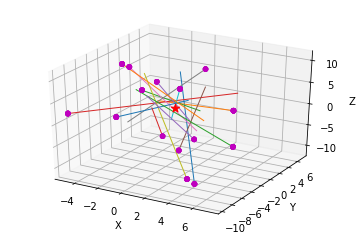

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='r',s=75,marker='*',zorder=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [84]:
S = np.array([[1,1,0],[0,1,1]]).T
V = form_V(S)
G = form_G(S,V)
# G[:3,3] = np.array([1,2,3])
covar1 = calculate_ellipse_covariance(S[:,0],a,b,)
# G[3:,4] = np.array([4,5,6

In [90]:
s

[[ 0.16666667 -0.16666667  0.16666667  0.83333333  0.16666667 -0.16666667]
 [-0.5         0.5         0.5         0.5         0.5        -0.5       ]
 [-0.16666667  0.16666667  0.83333333  0.16666667 -0.16666667  0.16666667]
 [-0.94280904 -0.47140452  0.47140452  0.94280904  0.47140452 -0.47140452]
 [-0.47140452  0.47140452  0.94280904  0.47140452 -0.47140452 -0.94280904]]
